In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d, UnivariateSpline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    ConstantKernel, RBF, ExpSineSquared, WhiteKernel
)
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [55]:
# Generate synthetic temperature time series for 15 days in May 2025
def generate_temperature_series():
    """Generate a realistic temperature time series with daily cycles"""
    # Create timestamps for 15 days (360 hours)
    start_date = datetime(2025, 5, 1, 0, 0, 0)
    timestamps = np.array([start_date + timedelta(hours=i) for i in range(360)])
    
    # Base temperature pattern with seasonal variation
    base_temp = 20 + 5 * np.sin(2 * np.pi * np.arange(360) / 24)  # Daily cycle
    
    # Add some weekly patterns (temperature varies slightly throughout the week)
    weekly_pattern = 2 * np.sin(2 * np.pi * np.arange(360) / 168)  # Weekly cycle
    
    # Add random noise
    noise = np.random.normal(0., 0.8, 360)  # Random fluctuations
    
    # Combine all components
    temperatures = base_temp + weekly_pattern + noise
    
    return timestamps, temperatures

# Function to introduce missing data with variable block lengths
def introduce_missing_data(timestamps, temperatures, f_missing=0.1):
    """
    Introduce missing data points with random block lengths between 1-10 samples
    
    Parameters:
    timestamps: list of datetime objects
    temperatures: array of temperature values
    f_missing: fraction of data points to remove (0 < f_missing < 1)
    
    Returns:
    timestamps_clean: list of timestamps without missing points
    temperatures_clean: array of temperatures without missing points
    missing_indices: indices of removed data points
    """
    
    n_points = len(temperatures)
    
    # Handle edge case
    if n_points <= 2:
        return timestamps.copy(), temperatures.copy(), []
    
    # Calculate how many points to remove
    n_missing = int(f_missing * n_points)
    n_missing = max(0, min(n_missing, n_points - 2))  # Keep at least 2 points
    
    # Initialize missing indices set
    missing_indices = set()
    
    # Generate missing blocks ensuring we don't touch first and last points
    while len(missing_indices) < n_missing:
        # Select random starting point (avoid first and last points)
        start_idx = np.random.randint(1, n_points - 1)  # Can start from index 1 to n_points-2
        
        # Select random block length (1-10 samples, but not exceeding remaining points)
        max_block_length = min(10, n_points - start_idx - 1)
        if max_block_length <= 0:
            continue
            
        block_length = np.random.randint(1, max_block_length + 1)
        
        # Add indices to missing set, avoiding first and last points
        for i in range(start_idx, min(start_idx + block_length, n_points - 1)):
            if i > 0:  # Ensure we don't remove the first point
                missing_indices.add(i)
        
        # Safety check to prevent infinite loop
        if len(missing_indices) >= n_points - 2:
            break
    
    # Convert to sorted list
    missing_indices = sorted(list(missing_indices))
    
    # Create clean indices (excluding missing indices)
    clean_indices = [i for i in range(n_points) if i not in missing_indices]
    
    # Create clean arrays
    timestamps_clean = timestamps[clean_indices]  #### if hasattr(timestamps, '__getitem__') else [timestamps[i] for i in clean_indices]
    temperatures_clean = temperatures[clean_indices] ### if hasattr(temperatures, '__getitem__') else [temperatures[i] for i in clean_indices]
    
    return timestamps_clean, temperatures_clean, missing_indices

Generating synthetic temperature time series...
Generated 360 data points
Removed 90 data points
Remaining points: 270


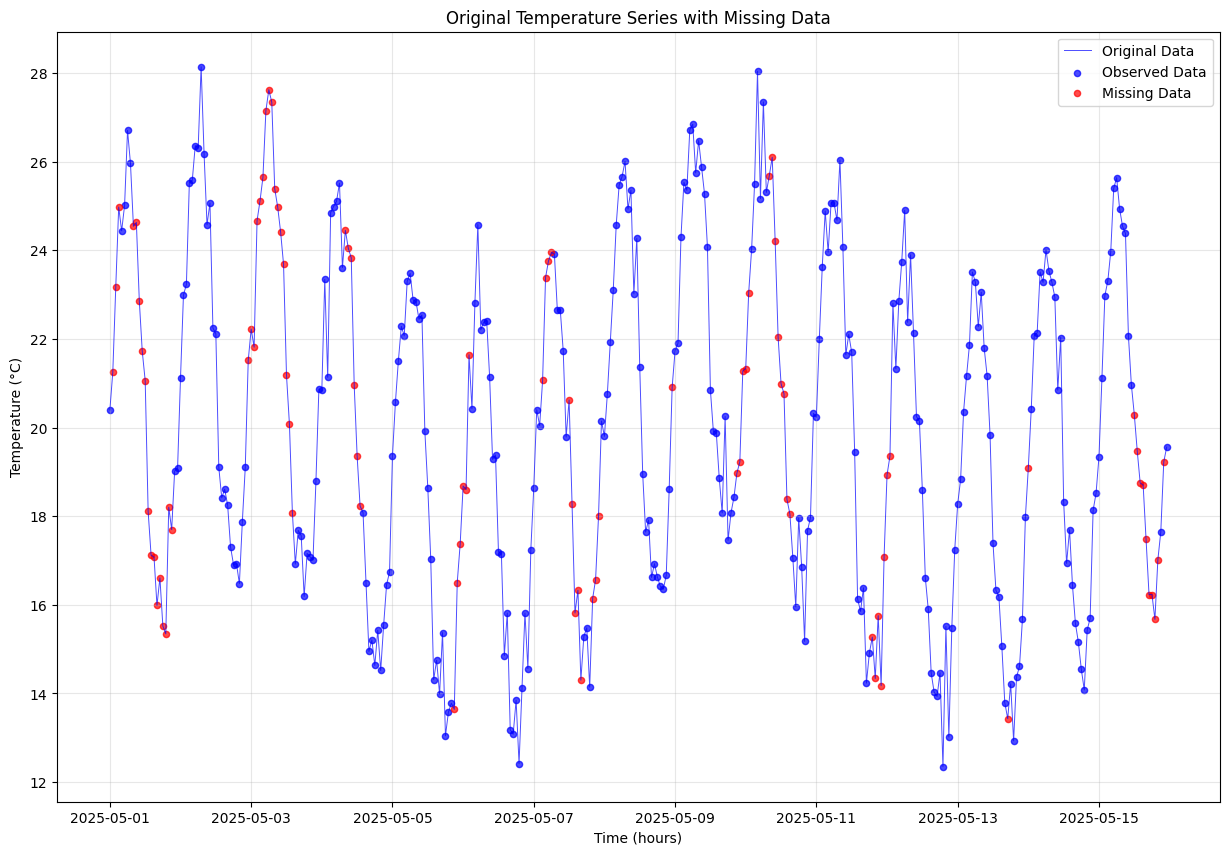

In [56]:
print("Generating synthetic temperature time series...")
    
# Generate temperature data
timestamps, temperatures = generate_temperature_series()
    
# Introduce missing data
f_missing = 0.25  # 15% missing data
timestamps_clean, temperatures_clean, missing_indices = introduce_missing_data(
        timestamps, temperatures, f_missing=f_missing
        )
    
print(f"Generated {len(temperatures)} data points")
print(f"Removed {len(missing_indices)} data points")
print(f"Remaining points: {len(temperatures_clean)}")

# Visualization
plt.figure(figsize=(15, 10))
    
# Plot 1: Original vs Missing Data
plt.plot(timestamps, temperatures, 'b-', linewidth=0.7, alpha=0.7, label='Original Data')
plt.scatter(timestamps_clean, temperatures_clean, c='blue', s=20, alpha=0.7, label='Observed Data')
plt.scatter(timestamps[missing_indices], temperatures[missing_indices], c='red', s=20, alpha=0.7, label='Missing Data')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.title('Original Temperature Series with Missing Data')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [57]:
# Constant: average value
def nearest_neighbor_interpolation(x_original, y_original, x_interp):
    n = len(x_original)
    idx = np.searchsorted(x_original, x_interp, side='left')
    left_idx = np.clip(idx - 1, 0, n - 1)
    right_idx = np.clip(idx, 0, n - 1)
    left_diff = np.abs(x_interp - x_original[left_idx])
    right_diff = np.abs(x_interp - x_original[right_idx])
    chosen_idx = np.where(left_diff <= right_diff, left_idx, right_idx)
    return y_original[chosen_idx]
    
# Linear interpolation function
def linear_interpolation(x_original, y_original, x_interp):
    """Perform linear interpolation"""
    f = interp1d(x_original, y_original, kind='linear')
    return f(x_interp)

# Polynomial interpolation function (degree 2 and 3)
def polynomial_interpolation(x_original, y_original, x_interp, degree=2):
    """
    Interpolates values using localized polynomial fitting of degree degree.
    
    Parameters:
    x_original (np.ndarray): 1D array of sorted, unique x-values (irregularly spaced).
    y_original (np.ndarray): 1D array of y-values corresponding to x_original.
    x_interp (np.ndarray): 1D array of x-values where interpolation is desired.
    d (int): Degree of the polynomial.
    
    Returns:
    np.ndarray: 1D array of interpolated y-values corresponding to x_interp.
    """
    n_orig = len(x_original)
    n_interp = len(x_interp)

    # Initialize results with NaN (in case some points are never covered)
    y_result = np.full(n_interp, np.nan)
    
    # Initialize a tracker for the "closeness" score (distance to window center).
    # We initialize with infinity so the first fit is always accepted.
    best_scores = np.full(n_interp, np.inf)

    # We need d+1 points to fit a polynomial of degree d.
    # The loop runs from 0 to n_orig - (d + 1).
    for i in range(n_orig - degree):
        
        # 1. Select the window of d+1 points
        x_window = x_original[i : i + degree + 1]
        y_window = y_original[i : i + degree + 1]
        
        # 2. Fit the polynomial
        coeffs = np.polyfit(x_window, y_window, degree)
        
        # 3. Define the range of this polynomial and its center
        x_min = x_window[0]
        x_max = x_window[-1]
        center = (x_min + x_max) / 2.0
        
        # 4. Find which x_interp points fall strictly within this polynomial's range
        # (Using numeric comparison handles irregular spacing automatically)
        in_range_mask = (x_interp >= x_min) & (x_interp <= x_max)
        
        if not np.any(in_range_mask):
            continue
            
        # Get the specific indices and values of x_interp that match
        indices = np.where(in_range_mask)[0]
        x_targets = x_interp[indices]
        
        # 5. Evaluate the polynomial for these targets
        y_candidates = np.polyval(coeffs, x_targets)
        
        # 6. Calculate the "closeness" score (distance to center)
        distances = np.abs(x_targets - center)
        
        # 7. Resolve overlaps: Keep the result where distance to center is smallest
        # Retrieve the current best scores for these specific indices
        current_best = best_scores[indices]
        
        # Find where the new distance is smaller than the old best
        better_fit_mask = distances < current_best
        
        # Indices where the new polynomial is a better fit
        indices_to_update = indices[better_fit_mask]
        
        if len(indices_to_update) > 0:
            # Update the result
            y_result[indices_to_update] = np.polyval(coeffs, x_interp[indices_to_update])
            # Update the tracker so we don't overwrite this with a worse fit later
            best_scores[indices_to_update] = distances[better_fit_mask]

    return y_result

# Newton interpolation using divided differences
def newton_interpolation(x_original, y_original, x_interp, window_size=5):
    """
    Newton interpolation with numerical stability improvements.
    Uses local windows and scaled x-values for stability.
    
    Parameters:
    - x_original: known x values (sparse, irregularly spaced)
    - y_original: known y values
    - x_interp: target x values (dense grid)
    - window_size: number of nearest neighbors for local interpolation
    
    Returns:
    - y_interp: interpolated y values
    """
    y_interp = np.full_like(x_interp, np.nan, dtype=np.float64)
    
    # Find valid x range
    x_min, x_max = x_original[0], x_original[-1]
    
    for i, x in enumerate(x_interp):
        # Skip if outside data range
        if x < x_min or x > x_max:
            continue
        
        # Find nearest window_size points
        distances = np.abs(x_original - x)
        nearest_idx = np.argsort(distances)[:window_size]
        nearest_idx = nearest_idx[np.argsort(x_original[nearest_idx])]  # Sort by x
        
        x_near = x_original[nearest_idx]
        y_near = y_original[nearest_idx]
        
        # Scale x to [0, 1] for numerical stability
        x_span = x_near[-1] - x_near[0]
        if x_span < 1e-10:
            # All x_near are essentially the same
            y_interp[i] = y_near.mean()
            continue
        
        x_scaled = (x_near - x_near[0]) / x_span
        x_target_scaled = (x - x_near[0]) / x_span
        
        # Compute divided differences (Newton coefficients)
        n = len(x_scaled)
        coeffs = y_near.copy().astype(np.float64)
        
        for j in range(1, n):
            for k in range(n-1, j-1, -1):
                denom = x_scaled[k] - x_scaled[k-j]
                if abs(denom) < 1e-15:
                    # Avoid division by zero - use average of neighbors
                    coeffs[k] = coeffs[k-1]
                else:
                    coeffs[k] = (coeffs[k] - coeffs[k-1]) / denom
        
        # Evaluate Newton polynomial using Horner's method
        result = coeffs[-1]
        for j in range(n-2, -1, -1):
            result = result * (x_target_scaled - x_scaled[j]) + coeffs[j]
        
        y_interp[i] = result
    
    return y_interp

    
# B-spline interpolation function
def bspline_interpolation(x_original, y_original, x_interp, k=3, smoothing_factor=0):
    """Perform B-spline interpolation"""
    if len(x_original) < k + 1:
        # If not enough points, fall back to linear interpolation
        f = interp1d(x_original, y_original, kind='linear')
        return f(x_interp)
    
    try:
        spline = UnivariateSpline(x_original, y_original, k=k, s=smoothing_factor)
        return spline(x_interp)
    except:
        # Fallback to linear if spline fitting fails
        f = interp1d(x_original, y_original, kind='linear')
        return f(x_interp)

# Gaussian Process interpolation
def gaussian_process_interpolation(x_original, y_original, x_interp):
    """
    Interpolate values at specified datetime points using Gaussian Process Regression.
    
    Parameters
    ----------
    x_original : numpy.ndarray
        Sorted 1D array of hours since start (no duplicates).
    y_original : numpy.ndarray
        1D array of values corresponding to x_original (no NaNs).
    x_interp : numpy.ndarray
        1D array of hours since start where interpolation is desired.
    
    Returns
    -------
    numpy.ndarray
        Interpolated values at x_interp points.
    """
    n_original = len(x_original)
    n_interp = len(x_interp)
    
    # Validate inputs
    if n_original != len(y_original):
        raise ValueError("x_original and y_original must have the same length")
    if n_interp == 0:
        return np.array([])
    if n_original < 3:
        raise ValueError("Not enough data points to train GP model.")
    
    # x values are already in hours since start and of type float
    t_original = x_original
    t_interp = x_interp
    
    # Normalize y values for numerical stability
    y_mean = np.mean(y_original)
    y_std = np.std(y_original)
    if y_std < 1e-10:
        return np.full(n_interp, y_mean)
    y_normalized = (y_original - y_mean) / y_std
    
    # Time periods in hours
    hours_per_day = 24.0
    hours_per_year = 365.25 * hours_per_day  # ~8766 hours
    
    # Kernel: captures smooth variations + daily periodicity + noise
    kernel = (
        # Overall amplitude
        ConstantKernel(1.0, constant_value_bounds=(1e-2, 1e2)) *
        (
            # Smooth non-periodic component
            RBF(length_scale=hours_per_day, length_scale_bounds=(1e1, 1e5)) +
            # Daily periodicity (24 hours)
            ExpSineSquared(
                length_scale=hours_per_day * 3,
                length_scale_bounds=(hours_per_day, hours_per_year),
                periodicity=hours_per_day
            )
        ) +
        # Noise term
        WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-4, 1e1))
    )
    
    # Number of optimizer restarts
    n_restarts = min(20, max(5, n_original // 10))
    
    # Initialize and fit GP model
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=n_restarts,
        random_state=42,
        normalize_y=False
    )
    
    try:
        gpr.fit(t_original.reshape(-1, 1), y_normalized)
    except Exception as e:
        print(f"GP fitting failed: {e}. Using linear interpolation.")
        return _linear_fallback(x_original, y_original, x_interp)
    
    # Predict at interpolation points
    y_interp_normalized = gpr.predict(t_interp.reshape(-1, 1))
    
    # Reverse normalization
    y_interp = y_interp_normalized * y_std + y_mean
    
    return y_interp

# Calculate interpolation errors
def calculate_errors(original_x, original_y, interpolated_y):
    """Calculate mean and maximum absolute errors"""
    # Find common x values for comparison
    common_x = np.intersect1d(original_x, original_x)  # This will be all points in original_x
    common_y = original_y
    
    # Interpolate original data to same points as interpolated data
    f = interp1d(original_x, original_y, kind='linear', fill_value='extrapolate')
    original_interpolated = f(interpolated_y)
    
    # Calculate errors
    errors = np.abs(common_y - interpolated_y)
    
    return {
        'mean_error': np.mean(errors),
        'max_error': np.max(errors)
    }


In [58]:
# Main execution

# Convert timestamps array to hours since start of timeseries
start_time = timestamps[0]
clean_x = (timestamps_clean - start_time).astype('timedelta64[h]').astype(float)
interp_x = (timestamps - start_time).astype('timedelta64[h]').astype(float)
    
# Perform all interpolation methods
print("\nPerforming interpolations...")
    
# Store results
results = {}
    
# Nearest neighbor interpolation
print("\n    nearest neighbor...")
results['Nearest'] = nearest_neighbor_interpolation(clean_x, temperatures_clean, interp_x)
    
# Linear interpolation
print("\n    linear...")
results['Linear'] = linear_interpolation(clean_x, temperatures_clean, interp_x)
    
# Polynomial interpolation (degree 2)
print("\n    poly 2...")
results['Polynomial_2'] = polynomial_interpolation(clean_x, temperatures_clean, interp_x, degree=2)
    
# Polynomial interpolation (degree 50)
print("\n    poly 3...")
results['Polynomial_3'] = polynomial_interpolation(clean_x, temperatures_clean, interp_x, degree=3)
    
# Newton interpolation
print("\n    newton...")
results['Newton'] = newton_interpolation(clean_x, temperatures_clean, interp_x, window_size=3)
    
# B-spline interpolation
print("\n    b-spline...")
results['B-spline'] = bspline_interpolation(clean_x, temperatures_clean, interp_x, k=3, smoothing_factor=0)
    
# Gaussian Process
print("\n    gaussian process...")
results['Gaussian Process'] = gaussian_process_interpolation(clean_x, temperatures_clean, interp_x)
    
# Calculate errors
print("\nCalculating errors...")
errors = {}
for method, interpolated_values in results.items():
    # Calculate errors compared to original data (where available)
    # We'll compare where both original and interpolated exist
    valid_indices = np.intersect1d(np.arange(len(temperatures)), np.arange(len(interpolated_values)))
    if len(valid_indices) > 0:
        orig_vals = temperatures[valid_indices]
        interp_vals = interpolated_values[valid_indices]
        errors[method] = {
            'mean_error': np.mean(np.abs(orig_vals - interp_vals)),
            'max_error': np.max(np.abs(orig_vals - interp_vals))
        }
        if np.abs(errors[method]['max_error']) > 50.:
            print(f"\nOutrageously large error for {method}: {errors[method]['max_error']}. Cut to 50 for visualisation.")
            errors[method] = {
                'mean_error': 50.,
                'max_error': 50.
            }
    else:
        errors[method] = {'mean_error': np.nan, 'max_error': np.nan}
print("\nDone.")


Performing interpolations...

    nearest neighbor...

    linear...

    poly 2...

    poly 3...

    newton...

    b-spline...

    gaussian process...

Calculating errors...

Done.


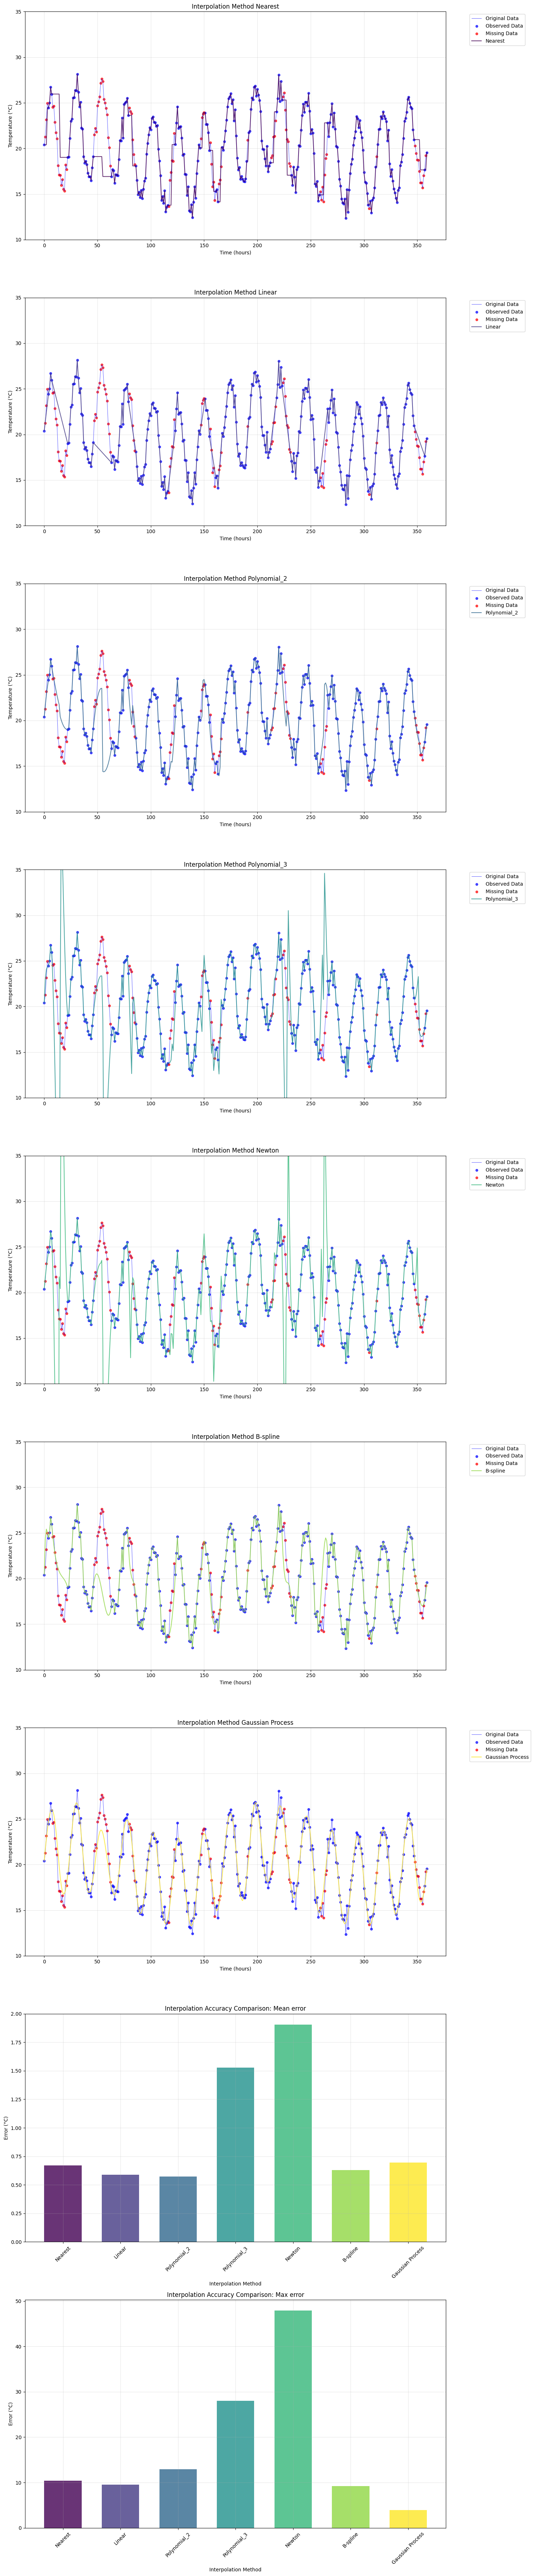

In [65]:
# Visualization
def get_smooth_distinguishable_colors(n):
    # 'viridis' is widely accepted as the standard for color-blind friendly plotting
    cmap = plt.get_cmap('viridis', n) 
    colors = []
    for i in range(n):
        # Get RGBA value (0 to 1 range)
        rgba = cmap(i)
        # Convert to Hex string
        hex_color = mcolors.to_hex(rgba)
        colors.append(hex_color)
    return colors

plt.figure(figsize=(15, 9*8))
    
# Plot 1: Interpolation Comparison
methods = list(results.keys())
colors = get_smooth_distinguishable_colors(len(methods))
    
for i, (method, color) in enumerate(zip(methods, colors)):
    plt.subplot(9, 1, i+1)
    plt.plot(interp_x, temperatures, 'b-', linewidth=0.7, alpha=0.7, label='Original Data')
    plt.scatter(clean_x, temperatures_clean, c='blue', s=20, alpha=0.7, label='Observed Data')
    plt.scatter(interp_x[missing_indices], temperatures[missing_indices], c='red', s=20, alpha=0.7, label='Missing Data')
    # limit results[method] for visibility
    plot_y = results[method]
    plot_y[plot_y > 50.] = 50.
    plot_y[plot_y < -50.] = -50.
    plt.plot(interp_x, plot_y, color=color, linewidth=1.5, 
            label=f'{method}', alpha=0.8)

    plt.ylim(10., 35.)
    plt.xlabel('Time (hours)')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Interpolation Method {method}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

# Plot 4: Error Comparison
mean_errors = [errors[method]['mean_error'] for method in methods]
max_errors = [errors[method]['max_error'] for method in methods]
"""    
x_pos = np.arange(len(methods))
width = 0.35
    
plt.bar(x_pos - width/2, mean_errors, width, label='Mean Error', alpha=0.8)
plt.bar(x_pos + width/2, max_errors, width, label='Max Error', alpha=0.8)
plt.xlabel('Interpolation Methods')
plt.ylabel('Error (°C)')
plt.title('Interpolation Accuracy Comparison')
plt.xticks(x_pos, methods, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
"""
x_pos = np.arange(len(methods))
width = 0.65
    
plt.subplot(9, 1, 8)
plt.bar(x_pos, mean_errors, width, label='Mean Error', color=colors, alpha=0.8)
plt.xlabel('Interpolation Method')
plt.ylabel('Error (°C)')
plt.title('Interpolation Accuracy Comparison: Mean error')
plt.xticks(x_pos, methods, rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(9, 1, 9)  
plt.bar(x_pos, max_errors, width, label='Max Error', color=colors, alpha=0.8)
plt.xlabel('Interpolation Method')
plt.ylabel('Error (°C)')
plt.title('Interpolation Accuracy Comparison: Max error')
plt.xticks(x_pos, methods, rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [60]:
# Print error table
print("\n" + "="*60)
print("INTERPOLATION ERROR COMPARISON")
print("="*60)
    
# Create DataFrame for better presentation
error_data = []
for method, error_dict in errors.items():
    error_data.append({
        'Method': method,
        'Mean Error (°C)': f"{error_dict['mean_error']:.4f}" if not np.isnan(error_dict['mean_error']) else "N/A",
        'Max Error (°C)': f"{error_dict['max_error']:.4f}" if not np.isnan(error_dict['max_error']) else "N/A"
    })
    
df_errors = pd.DataFrame(error_data)
print(df_errors.to_string(index=False))
    
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Original data points: {len(temperatures)}")
print(f"Missing data points: {len(missing_indices)} ({f_missing*100:.1f}%)")
print(f"Remaining observed points: {len(temperatures_clean)}")
print("\nInterpolation methods tested:")
for method in results.keys():
    print(f"  - {method}")



INTERPOLATION ERROR COMPARISON
          Method Mean Error (°C) Max Error (°C)
         Nearest          0.6709        10.4212
          Linear          0.5884         9.5470
    Polynomial_2          0.5733        12.9406
    Polynomial_3          1.5270        28.0321
          Newton          1.9050        47.9026
        B-spline          0.6291         9.2404
Gaussian Process          0.6961         3.9064

SUMMARY
Original data points: 360
Missing data points: 90 (25.0%)
Remaining observed points: 270

Interpolation methods tested:
  - Nearest
  - Linear
  - Polynomial_2
  - Polynomial_3
  - Newton
  - B-spline
  - Gaussian Process


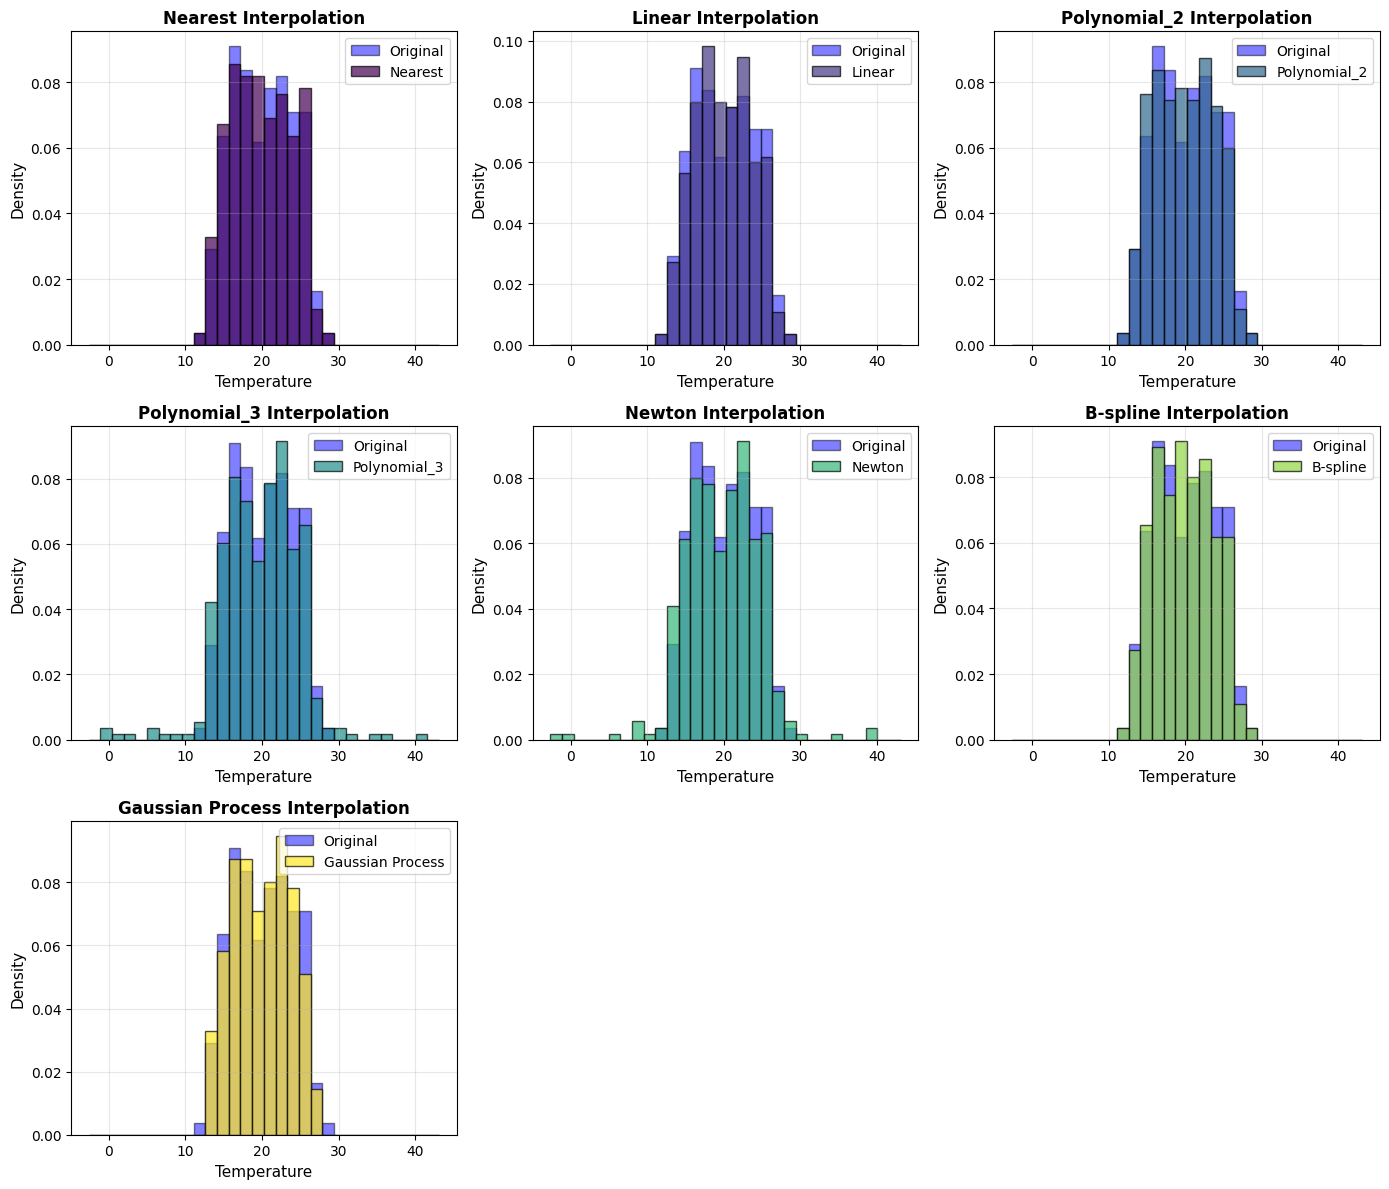

In [61]:
def plot_interpolation_histograms(results, temperatures, methods, colors):
    """
    Plot histograms of interpolated values for each method,
    with the original histogram superimposed.
    
    Parameters
    ----------
    results : dict
        Dictionary with method names as keys and numpy arrays of interpolated values.
    temperatures : numpy.ndarray
        Array of original temperature values for reference histogram.
    methods : list
        List of method names to plot.
    """
    n_methods = len(methods)
    
    # Determine subplot layout (2 rows x 3 columns for 6 methods)
    n_cols = 3
    n_rows = (n_methods + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten() if n_methods > 1 else [axes]
    
    # Common histogram settings
    alpha_original = 0.5
    alpha_interp = 0.7
    bins = 30
    xmin = temperatures.min() - 15.
    xmax = temperatures.max() + 15.
    
    for idx, method in enumerate(methods):
        ax = axes[idx]
        
        # Plot original temperature histogram
        ax.hist(temperatures, bins=bins, range=[xmin, xmax], alpha=alpha_original, 
                color='blue', label='Original', density=True, edgecolor='black')
        
        # Plot interpolated values histogram
        interp_values = results[method]
        ax.hist(interp_values, bins=bins, range=[xmin, xmax], alpha=alpha_interp, 
                color=colors[idx], label=f'{method}', density=True, edgecolor='black')
        
        # Labels and title
        ax.set_xlabel('Temperature', fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.set_title(f'{method} Interpolation', fontsize=12, fontweight='bold')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots if any
    for idx in range(n_methods, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('interpolation_histograms.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # return fig


plot_interpolation_histograms(results, temperatures, methods, colors)